In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter, defaultdict
from scipy import stats
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import warnings
warnings.filterwarnings('ignore')




# Working with Text Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll be looking at and exploring European restaurant reviews. The dataset is rather tiny, but that's just because it has to run on any machine. In real life, just like with images, texts can be several terabytes long.

The dataset is located [here](https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews) and as always, it's been provided to you in the `data/` folder.

### Problem 1. Read the dataset (1 point)
Read the dataset, get acquainted with it. Ensure the data is valid before you proceed.

How many observations are there? Which country is the most represented? What time range does the dataset represent?

Is the sample balanced in terms of restaurants, i.e., do you have an equal number of reviews for each one? Most importantly, is the dataset balanced in terms of **sentiment**?

=== DATASET OVERVIEW ===
Dataset shape: (1502, 6)
Number of observations: 1502
Number of features: 6


=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB
None


=== FIRST 5 ROWS ===
  Country            Restaurant Name Sentiment  \
0  France  The Frog at Bercy Village  Negative   
1  France  The Frog at Bercy Village  Negative   
2  France  The Frog at Bercy Village  Negative   
3  France  The Frog at Bercy Village  Negative   
4  France  The Frog at Bercy Village  Negative   

                                Review T

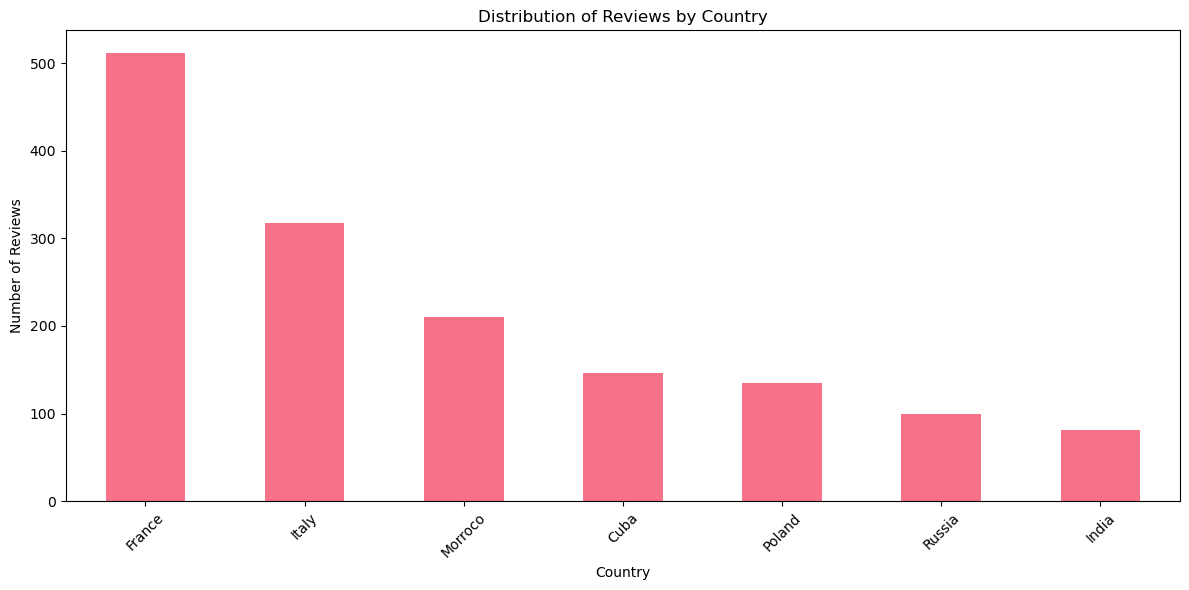



=== TIME RANGE ANALYSIS ===

Analyzing Review Date:
Sample values: ['May 2024 •', 'Feb 2024 •', 'Nov 2023 •', 'Mar 2023 •', 'Nov 2022 •']
Unique values count: 143
Date range: 2010-09-01 00:00:00 to 2024-07-01 00:00:00
Time span: 5052 days (13.8 years)
Years covered: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Number of different months: 139


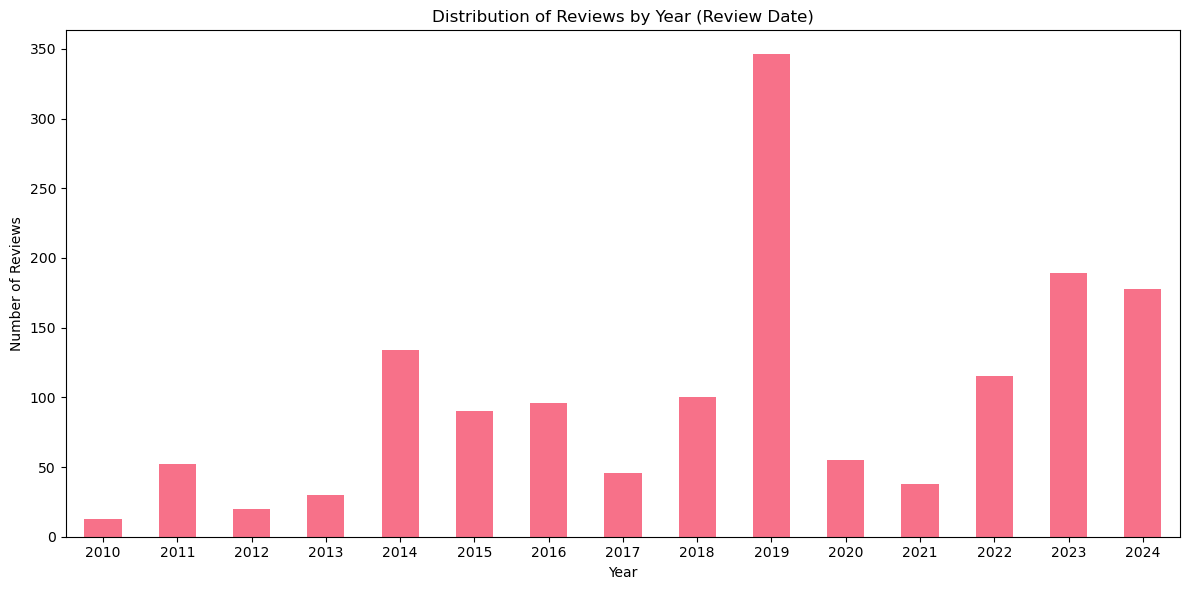

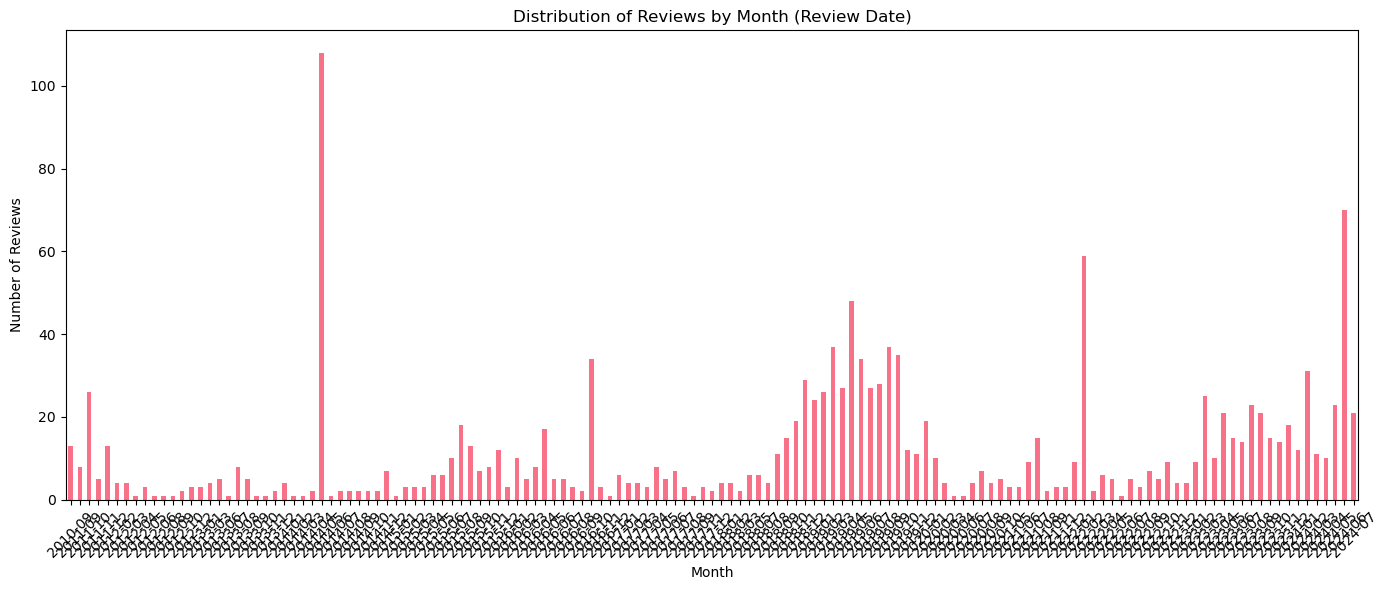



=== RESTAURANT BALANCE ANALYSIS ===

Analyzing Restaurant Name:
Number of unique restaurants: 7
Average reviews per restaurant: 214.57
Median reviews per restaurant: 146.00
Min reviews per restaurant: 81
Max reviews per restaurant: 512

Top 10 restaurants by number of reviews:
Restaurant Name
The Frog at Bercy Village                512
Ad Hoc Ristorante (Piazza del Popolo)    318
The LOFT                                 210
Old Square (Plaza Vieja)                 146
Stara Kamienica                          135
Pelmenya                                 100
Mosaic                                    81
Name: count, dtype: int64

Coefficient of variation: 0.715
⚠ Dataset is imbalanced across restaurants


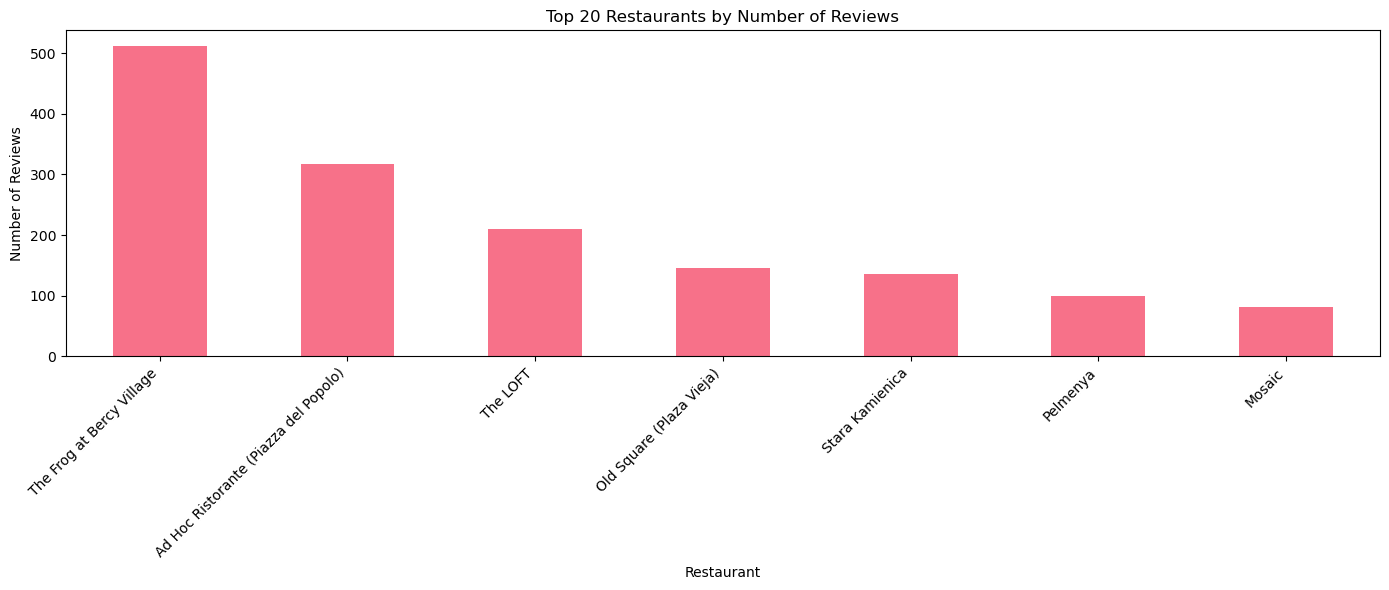



=== SENTIMENT BALANCE ANALYSIS ===

Analyzing Sentiment:
Sentiment distribution:
Sentiment
Negative     265
Positive    1237
Name: count, dtype: int64

Sentiment percentages:
Negative: 17.64%
Positive: 82.36%

Chi-square statistic for balance: 629.017
⚠ Dataset appears to be imbalanced in terms of sentiment


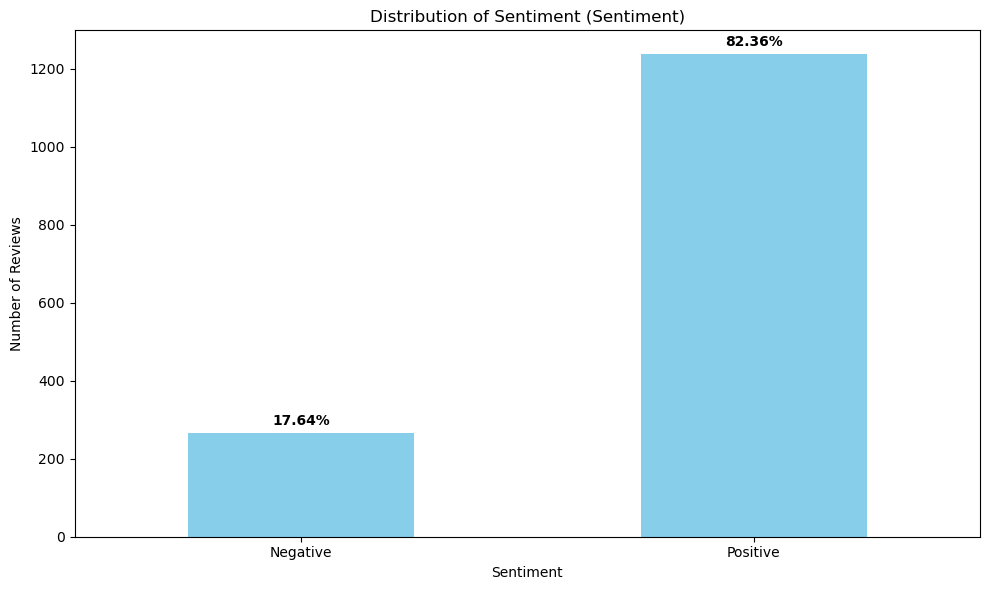



=== DATA VALIDATION ===
Checking data validity...
Number of duplicate rows: 49
Empty reviews in Review Title: 0
Empty reviews in Review Date: 0
Empty reviews in Review: 0
Empty reviews in Review Date_parsed: 0

=== PROBLEM 1 SUMMARY ===
✓ Total observations: 1502
✓ Most represented country: France (512 reviews)
✓ Time range: 2010-09-01 to 2024-07-01
✓ Restaurant balance: imbalanced (CV: 0.715)
✓ Sentiment balance: imbalanced (Chi-square: 629.017)


In [9]:

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Read the dataset
# Correct file path with spaces in filename
df = pd.read_csv('data\\European Restaurant Reviews.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Number of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("\n" + "="*50)

# Display basic info about the dataset
print("\n=== DATASET INFO ===")
print(df.info())
print("\n" + "="*50)

# Display first few rows to understand structure
print("\n=== FIRST 5 ROWS ===")
print(df.head())
print("\n" + "="*50)

# Check for missing values
print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])
print("\n" + "="*50)

# Basic statistics
print("\n=== BASIC STATISTICS ===")
print(df.describe(include='all'))
print("\n" + "="*50)

# Check column names to understand what we're working with
print("\n=== COLUMN NAMES ===")
print("Columns in dataset:", list(df.columns))
print("\n" + "="*50)

# Analyze country representation
print("\n=== COUNTRY ANALYSIS ===")
if 'country' in df.columns or 'Country' in df.columns:
    country_col = 'country' if 'country' in df.columns else 'Country'
    country_counts = df[country_col].value_counts()
    print("Country distribution:")
    print(country_counts)
    print(f"\nMost represented country: {country_counts.index[0]} ({country_counts.iloc[0]} reviews)")
    
    # Visualize country distribution
    plt.figure(figsize=(12, 6))
    country_counts.plot(kind='bar')
    plt.title('Distribution of Reviews by Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No 'country' or 'Country' column found. Available columns:", list(df.columns))

print("\n" + "="*50)

# Analyze time range
print("\n=== TIME RANGE ANALYSIS ===")
# More specific search for date columns, excluding sentiment
date_columns = [col for col in df.columns if ('date' in col.lower() or 'time' in col.lower()) 
                and 'sentiment' not in col.lower()]

if date_columns:
    for date_col in date_columns:
        print(f"\nAnalyzing {date_col}:")
        try:
            # Check original data before conversion
            print(f"Sample values: {df[date_col].head().tolist()}")
            print(f"Unique values count: {df[date_col].nunique()}")
            
            # Handle the specific format "May 2024 •" etc.
            def parse_review_date(date_str):
                if pd.isna(date_str):
                    return pd.NaT
                # Remove the bullet point and extra spaces
                date_str = str(date_str).replace('•', '').strip()
                try:
                    # Parse format like "May 2024", "January 2023", etc.
                    return pd.to_datetime(date_str, format='%B %Y')
                except:
                    try:
                        # Fallback to general parsing
                        return pd.to_datetime(date_str, errors='coerce')
                    except:
                        return pd.NaT
            
            # Apply custom parsing
            df[f'{date_col}_parsed'] = df[date_col].apply(parse_review_date)
            
            # Check for valid dates
            valid_dates = df[f'{date_col}_parsed'].dropna()
            if len(valid_dates) > 0:
                print(f"Date range: {valid_dates.min()} to {valid_dates.max()}")
                time_span = (valid_dates.max() - valid_dates.min()).days
                print(f"Time span: {time_span} days ({time_span/365.25:.1f} years)")
                
                # Show distribution by year and month
                years = valid_dates.dt.year
                months = valid_dates.dt.to_period('M')
                
                print(f"Years covered: {sorted(years.unique())}")
                print(f"Number of different months: {months.nunique()}")
                
                # Plot year distribution
                if years.nunique() > 1:
                    plt.figure(figsize=(12, 6))
                    years.value_counts().sort_index().plot(kind='bar')
                    plt.title(f'Distribution of Reviews by Year ({date_col})')
                    plt.xlabel('Year')
                    plt.ylabel('Number of Reviews')
                    plt.xticks(rotation=0)
                    plt.tight_layout()
                    plt.show()
                
                # Plot monthly distribution if we have enough variation
                if months.nunique() > 3:
                    plt.figure(figsize=(14, 6))
                    month_counts = months.value_counts().sort_index()
                    month_counts.plot(kind='bar')
                    plt.title(f'Distribution of Reviews by Month ({date_col})')
                    plt.xlabel('Month')
                    plt.ylabel('Number of Reviews')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"Limited monthly variation - showing month counts:")
                    print(months.value_counts().sort_index())
                    
            else:
                print("No valid dates found after parsing")
                print("Sample problematic values:", df[date_col].head(10).tolist())
                
        except Exception as e:
            print(f"Error processing {date_col}: {e}")
            import traceback
            print("Full error:", traceback.format_exc())
else:
    print("No date columns found. Available columns:", list(df.columns))
    # Show what columns exist for debugging
    print("All columns:", [col for col in df.columns])

print("\n" + "="*50)

# Analyze restaurant balance
print("\n=== RESTAURANT BALANCE ANALYSIS ===")
restaurant_columns = [col for col in df.columns if 'restaurant' in col.lower() or 'name' in col.lower()]
if restaurant_columns:
    for rest_col in restaurant_columns:
        print(f"\nAnalyzing {rest_col}:")
        restaurant_counts = df[rest_col].value_counts()
        print(f"Number of unique restaurants: {len(restaurant_counts)}")
        print(f"Average reviews per restaurant: {restaurant_counts.mean():.2f}")
        print(f"Median reviews per restaurant: {restaurant_counts.median():.2f}")
        print(f"Min reviews per restaurant: {restaurant_counts.min()}")
        print(f"Max reviews per restaurant: {restaurant_counts.max()}")
        
        print("\nTop 10 restaurants by number of reviews:")
        print(restaurant_counts.head(10))
        
        # Check balance
        std_dev = restaurant_counts.std()
        mean_reviews = restaurant_counts.mean()
        cv = std_dev / mean_reviews  # Coefficient of variation
        print(f"\nCoefficient of variation: {cv:.3f}")
        if cv < 0.5:
            print("✓ Dataset is relatively balanced across restaurants")
        else:
            print("⚠ Dataset is imbalanced across restaurants")
        
        # Visualize restaurant distribution
        plt.figure(figsize=(14, 6))
        restaurant_counts.head(20).plot(kind='bar')
        plt.title('Top 20 Restaurants by Number of Reviews')
        plt.xlabel('Restaurant')
        plt.ylabel('Number of Reviews')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        break  # Only analyze first restaurant column found
else:
    print("No restaurant name columns found. Available columns:", list(df.columns))

print("\n" + "="*50)

# Analyze sentiment balance - this is the most important part
print("\n=== SENTIMENT BALANCE ANALYSIS ===")
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower() or 'score' in col.lower()]

if sentiment_columns:
    for sent_col in sentiment_columns:
        print(f"\nAnalyzing {sent_col}:")
        sentiment_counts = df[sent_col].value_counts().sort_index()
        print("Sentiment distribution:")
        print(sentiment_counts)
        
        # Calculate balance metrics
        total_reviews = len(df)
        sentiment_percentages = (sentiment_counts / total_reviews * 100).round(2)
        print(f"\nSentiment percentages:")
        for sentiment, percentage in sentiment_percentages.items():
            print(f"{sentiment}: {percentage}%")
        
        # Check if balanced (roughly equal distribution)
        expected_per_class = total_reviews / len(sentiment_counts)
        chi_square = sum((count - expected_per_class)**2 / expected_per_class for count in sentiment_counts)
        print(f"\nChi-square statistic for balance: {chi_square:.3f}")
        
        if chi_square < 10:  # Rough threshold
            print("✓ Dataset appears to be balanced in terms of sentiment")
        else:
            print("⚠ Dataset appears to be imbalanced in terms of sentiment")
        
        # Visualize sentiment distribution
        plt.figure(figsize=(10, 6))
        sentiment_counts.plot(kind='bar', color=['red', 'orange', 'green'] if len(sentiment_counts) == 3 else 'skyblue')
        plt.title(f'Distribution of Sentiment ({sent_col})')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Reviews')
        plt.xticks(rotation=0)
        
        # Add percentage labels on bars
        for i, (sentiment, count) in enumerate(sentiment_counts.items()):
            plt.text(i, count + total_reviews*0.01, f'{sentiment_percentages[sentiment]}%', 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        break  # Only analyze first sentiment column found
else:
    print("No sentiment/rating columns found. Available columns:", list(df.columns))

print("\n" + "="*50)

# Data validation checks
print("\n=== DATA VALIDATION ===")
print("Checking data validity...")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Check for empty text reviews (if text column exists)
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
if text_columns:
    for text_col in text_columns:
        empty_reviews = df[text_col].isna().sum() + (df[text_col] == '').sum()
        print(f"Empty reviews in {text_col}: {empty_reviews}")

# Final summary for Problem 1
print("\n" + "="*70)
print("=== PROBLEM 1 SUMMARY ===")
print(f"✓ Total observations: {df.shape[0]}")
if 'country_counts' in locals():
    print(f"✓ Most represented country: {country_counts.index[0]} ({country_counts.iloc[0]} reviews)")
if 'date_col' in locals() and df[f'{date_col}_parsed'].notna().any():
    print(f"✓ Time range: {df[f'{date_col}_parsed'].min().strftime('%Y-%m-%d')} to {df[f'{date_col}_parsed'].max().strftime('%Y-%m-%d')}")
if 'restaurant_counts' in locals():
    balance_status = "balanced" if cv < 0.5 else "imbalanced"
    print(f"✓ Restaurant balance: {balance_status} (CV: {cv:.3f})")
if 'sentiment_counts' in locals():
    sentiment_balance = "balanced" if chi_square < 10 else "imbalanced"
    print(f"✓ Sentiment balance: {sentiment_balance} (Chi-square: {chi_square:.3f})")
print("="*70)

### Problem 2. Getting acquainted with reviews (1 point)
Are positive comments typically shorter or longer? Try to define a good, robust metric for "length" of a text; it's not necessary just the character count. Can you explain your findings?

=== PROBLEM 2: REVIEW LENGTH vs SENTIMENT ANALYSIS ===
Analyzing relationship between review sentiment and text length
Text columns found: ['Review Title', 'Review Date', 'Review']
Sentiment columns found: ['Sentiment']

Using 'Review Title' for text analysis
Using 'Sentiment' for sentiment analysis
Clean dataset size: 1502 reviews (removed 0 with missing data)

Sentiment distribution:
Sentiment
Positive    1237
Negative     265
Name: count, dtype: int64

=== DEFINING ROBUST TEXT LENGTH METRICS ===
Calculating text metrics for all reviews...
Text length metrics calculated:
  • char_count: Character count (no spaces)
  • word_count: Total word count
  • sentence_count: Number of sentences
  • avg_word_length: Average word length
  • content_word_count: Content words (no stop words)
  • unique_word_count: Unique words
  • lexical_diversity: Lexical diversity (TTR)

Sample review analysis:
Text: '5 stars...'
Sentiment: Positive
Metrics:
  char_count: 6.00
  word_count: 2.00
  sentence_cou

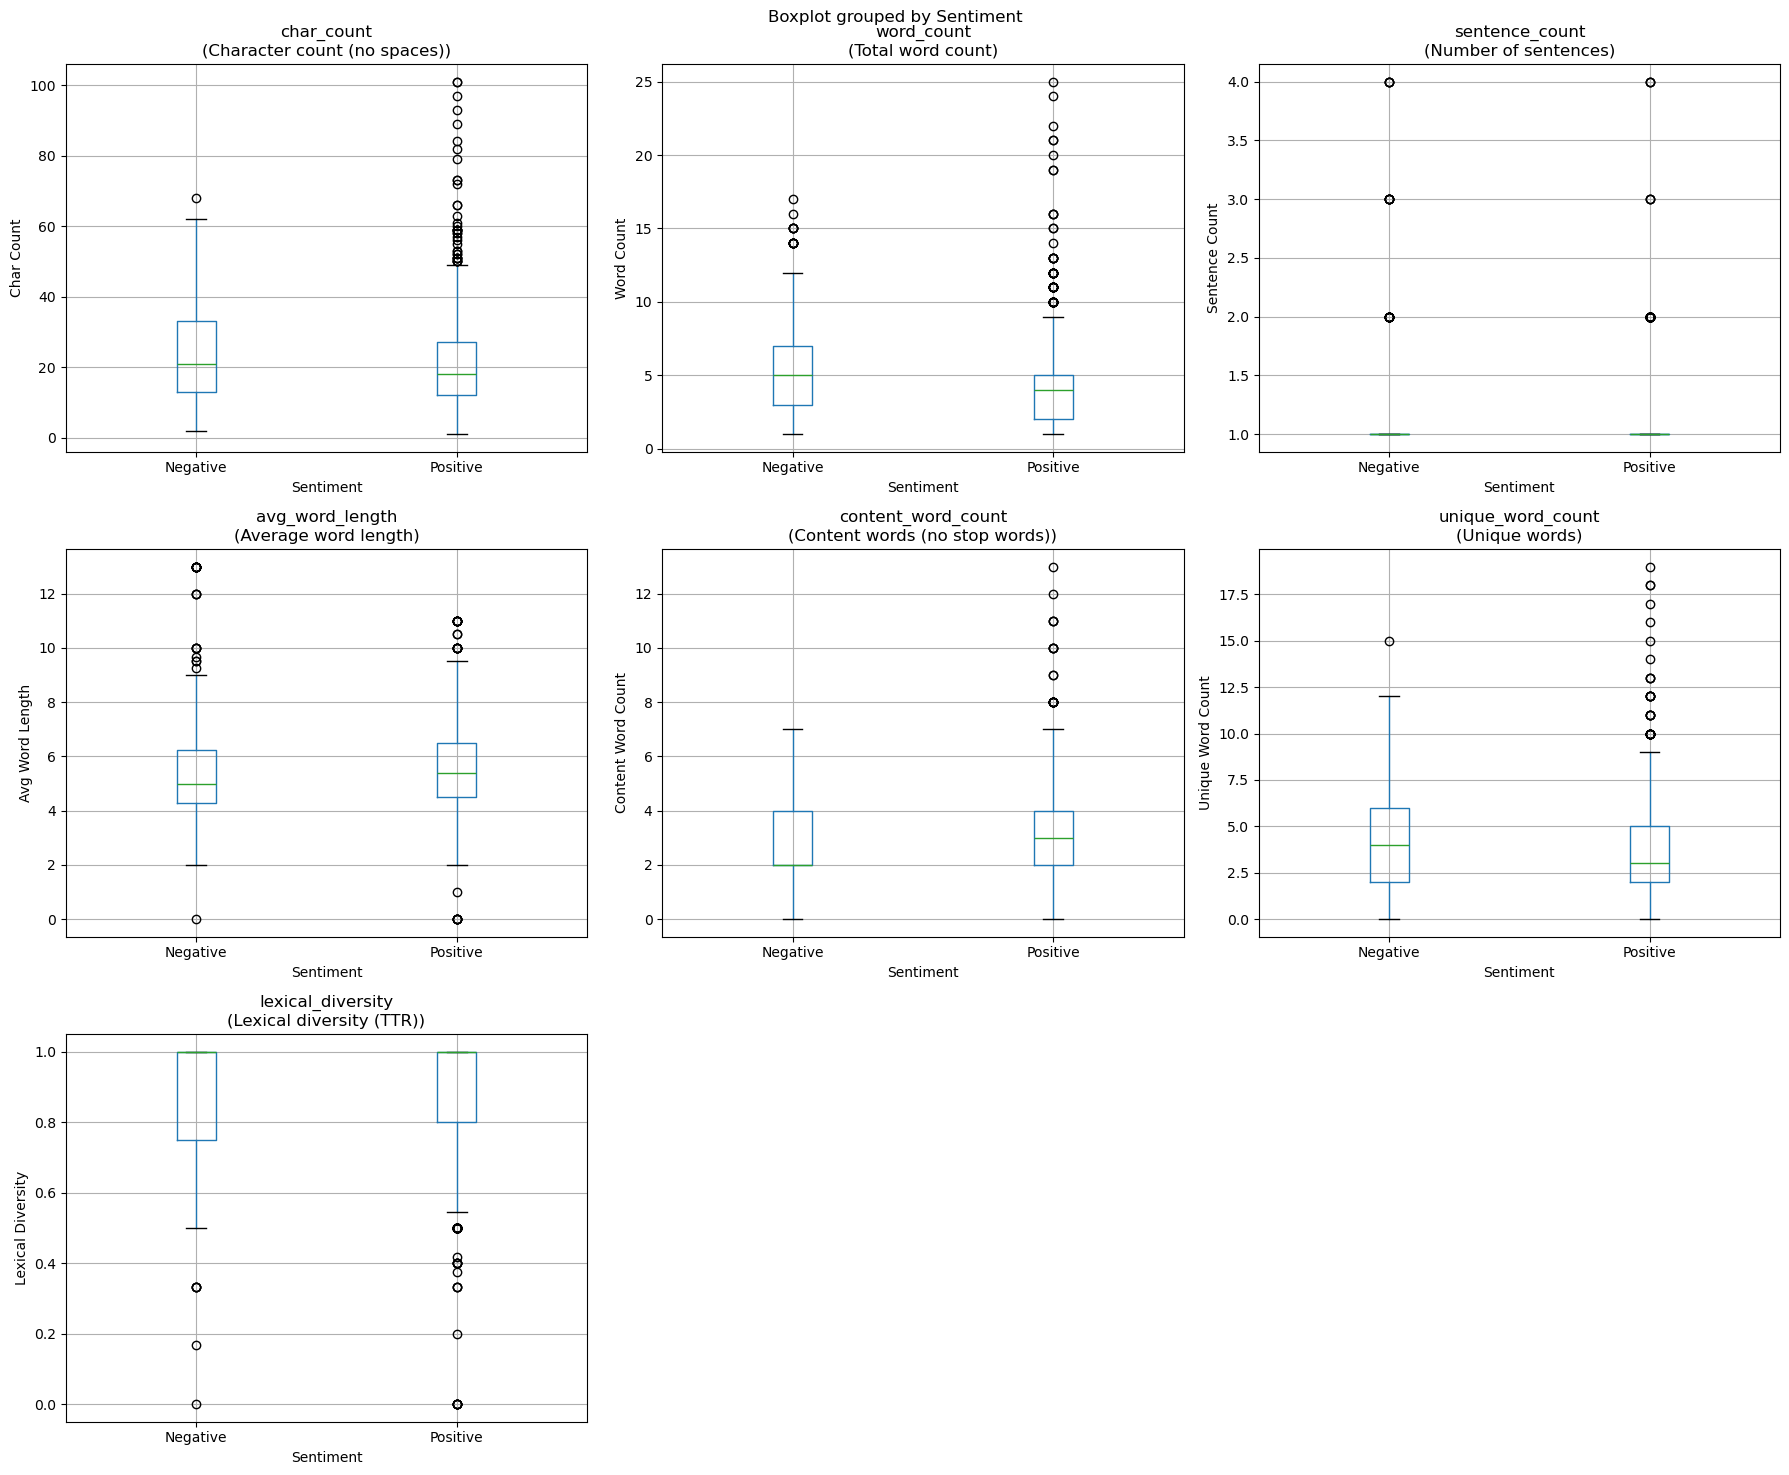

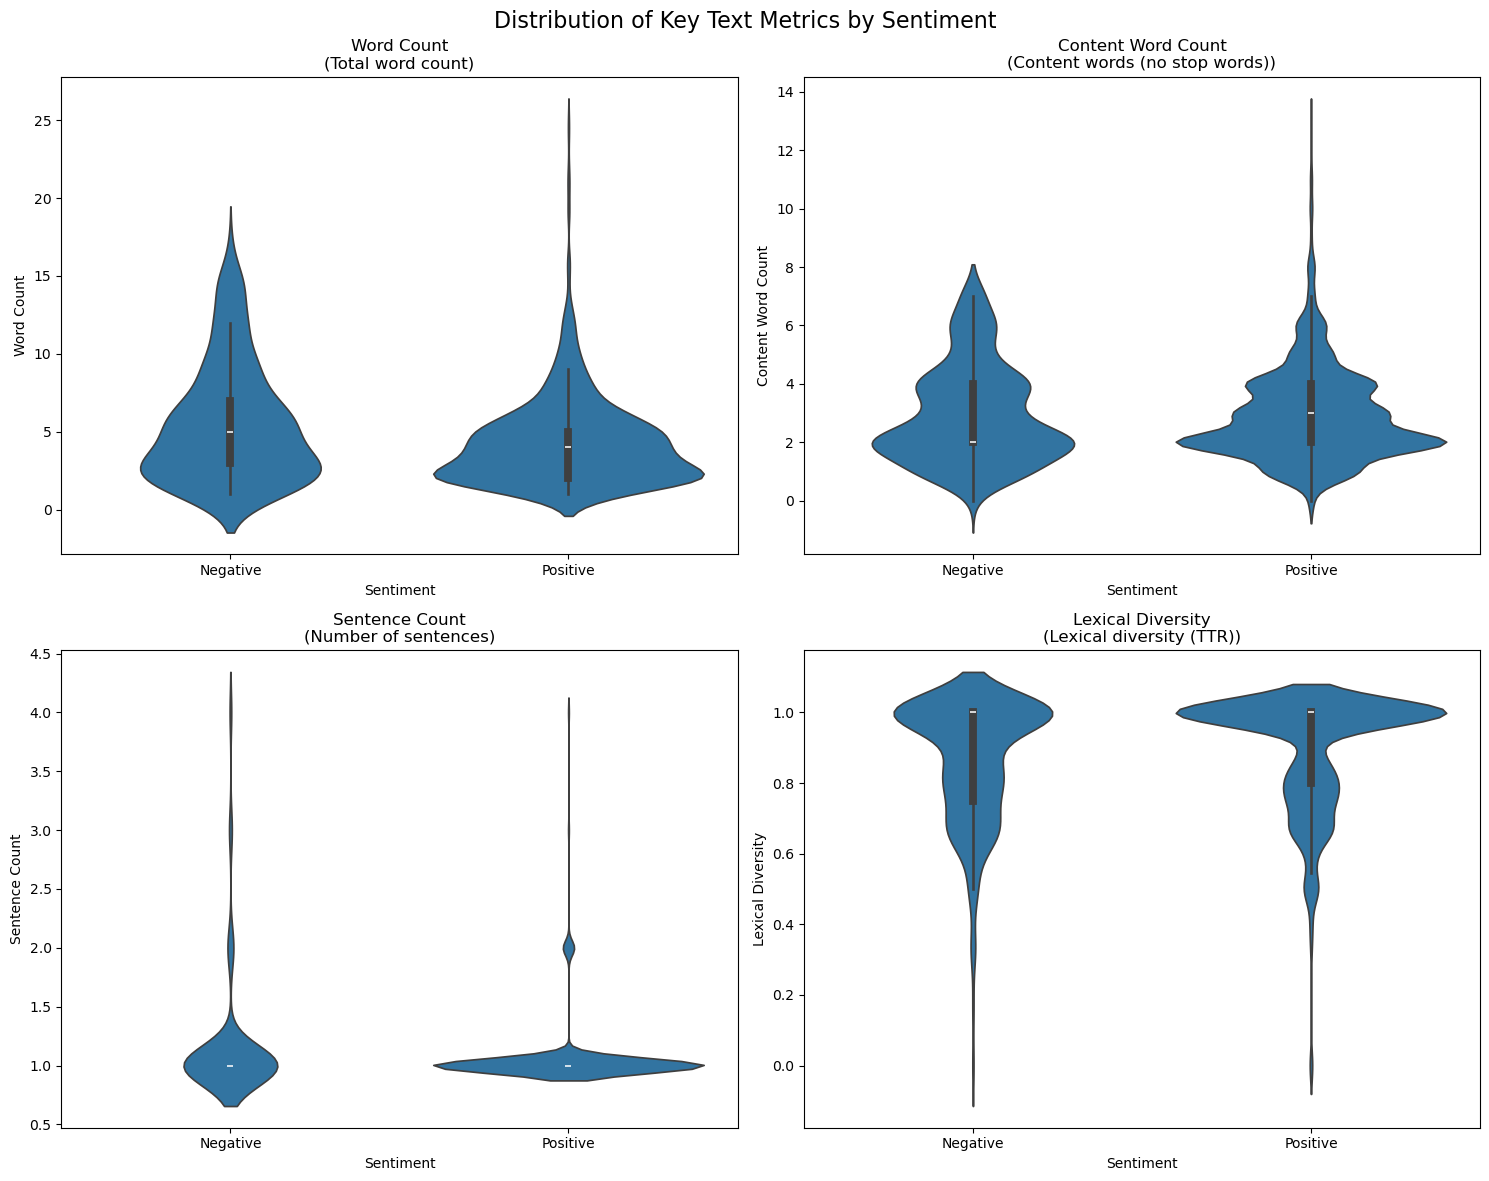


=== FINDINGS AND INTERPRETATION ===
MAIN FINDINGS:
1. REVIEW LENGTH RANKING (by average word count):
   1. Negative: 5.5 words on average
   2. Positive: 4.3 words on average

2. KEY OBSERVATIONS:
   • Negative reviews are 1.1 words longer on average
   • This represents a 26.4% difference

3. CONTENT RICHNESS:
   • Negative: 53.9% content words, 0.865 lexical diversity
   • Positive: 67.6% content words, 0.893 lexical diversity

4. RECOMMENDED LENGTH METRIC:
   Based on this analysis, the most robust length metrics are:
   • WORD COUNT: Most intuitive and commonly used
   • CONTENT WORD COUNT: Excludes stop words, focuses on meaningful content
   • SENTENCE COUNT: Captures structural complexity
   • LEXICAL DIVERSITY: Measures vocabulary richness

   Character count alone is less reliable because it doesn't account for
   meaningful content structure, while word-based metrics better capture
   the actual information density and effort invested in writing.


In [ ]:
# Download required NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Download punkt_tab if missing
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords


# Read the dataset
df = pd.read_csv('data\\European Restaurant Reviews.csv')

print("=== PROBLEM 2: REVIEW LENGTH vs SENTIMENT ANALYSIS ===")
print("Analyzing relationship between review sentiment and text length")
print("="*70)

# First, identify the review text and sentiment columns
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower()]

print(f"Text columns found: {text_columns}")
print(f"Sentiment columns found: {sentiment_columns}")

if not text_columns or not sentiment_columns:
    print("Available columns:", list(df.columns))
    print("\nPlease check column names in your dataset!")
    exit()

# Use the first available columns
text_col = text_columns[0]
sentiment_col = sentiment_columns[0]

print(f"\nUsing '{text_col}' for text analysis")
print(f"Using '{sentiment_col}' for sentiment analysis")
print("="*70)

# Clean data - remove rows with missing text or sentiment
df_clean = df.dropna(subset=[text_col, sentiment_col]).copy()
print(f"Clean dataset size: {len(df_clean)} reviews (removed {len(df) - len(df_clean)} with missing data)")

# Show sentiment distribution
print(f"\nSentiment distribution:")
sentiment_counts = df_clean[sentiment_col].value_counts()
print(sentiment_counts)

print("\n" + "="*70)
print("=== DEFINING ROBUST TEXT LENGTH METRICS ===")

# Define multiple robust metrics for text length
def calculate_text_metrics(text):
    """Calculate various text length metrics"""
    if pd.isna(text) or text == '':
        return {
            'char_count': 0,
            'word_count': 0,
            'sentence_count': 0,
            'avg_word_length': 0,
            'content_word_count': 0,
            'unique_word_count': 0,
            'lexical_diversity': 0
        }
    
    text_str = str(text).strip()
    
    # 1. Character count (excluding whitespace)
    char_count = len(text_str.replace(' ', ''))
    
    # 2. Word count
    words = word_tokenize(text_str.lower())
    word_count = len(words)
    
    # 3. Sentence count
    sentences = sent_tokenize(text_str)
    sentence_count = len(sentences)
    
    # 4. Average word length
    word_lengths = [len(word) for word in words if word.isalpha()]
    avg_word_length = np.mean(word_lengths) if word_lengths else 0
    
    # 5. Content word count (excluding stop words and punctuation)
    stop_words = set(stopwords.words('english'))
    content_words = [word for word in words if word.isalpha() and word.lower() not in stop_words]
    content_word_count = len(content_words)
    
    # 6. Unique word count
    unique_words = set(word.lower() for word in words if word.isalpha())
    unique_word_count = len(unique_words)
    
    # 7. Lexical diversity (Type-Token Ratio)
    lexical_diversity = unique_word_count / word_count if word_count > 0 else 0
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'content_word_count': content_word_count,
        'unique_word_count': unique_word_count,
        'lexical_diversity': lexical_diversity
    }

# Calculate metrics for all reviews
print("Calculating text metrics for all reviews...")
metrics_list = []
for idx, text in df_clean[text_col].items():
    metrics = calculate_text_metrics(text)
    metrics['index'] = idx
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('index', inplace=True)

# Merge with original data
df_analysis = df_clean.join(metrics_df)

print("Text length metrics calculated:")
metric_descriptions = {
    'char_count': 'Character count (no spaces)',
    'word_count': 'Total word count',
    'sentence_count': 'Number of sentences',
    'avg_word_length': 'Average word length',
    'content_word_count': 'Content words (no stop words)',
    'unique_word_count': 'Unique words',
    'lexical_diversity': 'Lexical diversity (TTR)'
}

for metric, description in metric_descriptions.items():
    print(f"  • {metric}: {description}")

# Show sample calculations
print(f"\nSample review analysis:")
sample_idx = df_analysis.sample(1).index[0]
sample_text = df_analysis.loc[sample_idx, text_col]
sample_sentiment = df_analysis.loc[sample_idx, sentiment_col]

print(f"Text: '{sample_text[:100]}...'")
print(f"Sentiment: {sample_sentiment}")
print("Metrics:")
for metric in metric_descriptions.keys():
    value = df_analysis.loc[sample_idx, metric]
    print(f"  {metric}: {value:.2f}")

print("\n" + "="*70)
print("=== STATISTICAL ANALYSIS BY SENTIMENT ===")

# Group by sentiment and analyze each metric
sentiments = df_analysis[sentiment_col].unique()
metrics_to_analyze = list(metric_descriptions.keys())

# Calculate statistics by sentiment
stats_by_sentiment = {}
for sentiment in sentiments:
    sentiment_data = df_analysis[df_analysis[sentiment_col] == sentiment]
    stats_by_sentiment[sentiment] = {}
    
    for metric in metrics_to_analyze:
        values = sentiment_data[metric]
        stats_by_sentiment[sentiment][metric] = {
            'mean': values.mean(),
            'median': values.median(),
            'std': values.std(),
            'count': len(values)
        }

# Create summary table
print("SUMMARY STATISTICS BY SENTIMENT:")
print("-" * 90)
for metric in metrics_to_analyze:
    print(f"\n{metric.upper()} ({metric_descriptions[metric]}):")
    print(f"{'Sentiment':<15} {'Mean':<10} {'Median':<10} {'Std Dev':<10} {'Count':<8}")
    print("-" * 60)
    
    for sentiment in sentiments:
        stats = stats_by_sentiment[sentiment][metric]
        print(f"{sentiment:<15} {stats['mean']:<10.2f} {stats['median']:<10.2f} {stats['std']:<10.2f} {stats['count']:<8}")

print("\n" + "="*70)
print("=== STATISTICAL SIGNIFICANCE TESTS ===")

# Perform statistical tests to compare sentiments
from scipy.stats import kruskal, mannwhitneyu

# If we have more than 2 sentiment categories, use Kruskal-Wallis
# If exactly 2, use Mann-Whitney U test

for metric in metrics_to_analyze:
    print(f"\n{metric.upper()}:")
    
    # Prepare data for statistical tests
    groups = [df_analysis[df_analysis[sentiment_col] == sentiment][metric].values 
              for sentiment in sentiments]
    
    # Remove empty groups
    groups = [group for group in groups if len(group) > 0]
    
    if len(groups) == 2:
        # Mann-Whitney U test for 2 groups
        try:
            statistic, p_value = mannwhitneyu(groups[0], groups[1], alternative='two-sided')
            print(f"  Mann-Whitney U test: statistic={statistic:.3f}, p-value={p_value:.6f}")
            
            # Effect size (Cohen's d approximation)
            group1_mean, group2_mean = np.mean(groups[0]), np.mean(groups[1])
            pooled_std = np.sqrt(((len(groups[0])-1)*np.var(groups[0]) + 
                                 (len(groups[1])-1)*np.var(groups[1])) / 
                                (len(groups[0]) + len(groups[1]) - 2))
            cohens_d = (group1_mean - group2_mean) / pooled_std if pooled_std > 0 else 0
            print(f"  Effect size (Cohen's d): {cohens_d:.3f}")
            
            # Interpretation
            if p_value < 0.001:
                significance = "highly significant (***)"
            elif p_value < 0.01:
                significance = "very significant (**)"
            elif p_value < 0.05:
                significance = "significant (*)"
            else:
                significance = "not significant"
            
            print(f"  Result: {significance}")
            
        except Exception as e:
            print(f"  Error in statistical test: {e}")
    
    elif len(groups) > 2:
        # Kruskal-Wallis test for multiple groups
        try:
            statistic, p_value = kruskal(*groups)
            print(f"  Kruskal-Wallis test: statistic={statistic:.3f}, p-value={p_value:.6f}")
            
            if p_value < 0.001:
                significance = "highly significant (***)"
            elif p_value < 0.01:
                significance = "very significant (**)"
            elif p_value < 0.05:
                significance = "significant (*)"
            else:
                significance = "not significant"
            
            print(f"  Result: {significance}")
            
        except Exception as e:
            print(f"  Error in statistical test: {e}")

print("\n" + "="*70)
print("=== VISUALIZATIONS ===")

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Text Length Metrics by Sentiment', fontsize=16, y=0.98)

for i, metric in enumerate(metrics_to_analyze):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Box plot
    df_analysis.boxplot(column=metric, by=sentiment_col, ax=ax)
    ax.set_title(f'{metric}\n({metric_descriptions[metric]})')
    ax.set_xlabel('Sentiment')
    ax.set_ylabel(metric.replace('_', ' ').title())
    
    # Remove the automatic title from pandas boxplot
    ax.set_title(f'{metric}\n({metric_descriptions[metric]})')

# Remove extra subplots if any
if len(metrics_to_analyze) < 9:
    for i in range(len(metrics_to_analyze), 9):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Create violin plots for better distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Key Text Metrics by Sentiment', fontsize=16)

key_metrics = ['word_count', 'content_word_count', 'sentence_count', 'lexical_diversity']
for i, metric in enumerate(key_metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    sns.violinplot(data=df_analysis, x=sentiment_col, y=metric, ax=ax)
    ax.set_title(f'{metric.replace("_", " ").title()}\n({metric_descriptions[metric]})')
    ax.set_xlabel('Sentiment')
    ax.set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("=== FINDINGS AND INTERPRETATION ===")

# Determine which sentiment has longer/shorter reviews
word_count_by_sentiment = {}
for sentiment in sentiments:
    sentiment_data = df_analysis[df_analysis[sentiment_col] == sentiment]
    word_count_by_sentiment[sentiment] = sentiment_data['word_count'].mean()

# Sort by word count
sorted_sentiments = sorted(word_count_by_sentiment.items(), key=lambda x: x[1], reverse=True)

print("MAIN FINDINGS:")
print(f"1. REVIEW LENGTH RANKING (by average word count):")
for i, (sentiment, avg_words) in enumerate(sorted_sentiments, 1):
    print(f"   {i}. {sentiment}: {avg_words:.1f} words on average")

print(f"\n2. KEY OBSERVATIONS:")

# Compare positive vs negative (if available)
if len(sentiments) >= 2:
    longest_sentiment = sorted_sentiments[0][0]
    shortest_sentiment = sorted_sentiments[-1][0]
    
    longest_avg = sorted_sentiments[0][1]
    shortest_avg = sorted_sentiments[-1][1]
    
    difference = longest_avg - shortest_avg
    percent_diff = (difference / shortest_avg) * 100
    
    print(f"   • {longest_sentiment} reviews are {difference:.1f} words longer on average")
    print(f"   • This represents a {percent_diff:.1f}% difference")

# Content vs total words
print(f"\n3. CONTENT RICHNESS:")
for sentiment in sentiments:
    sentiment_data = df_analysis[df_analysis[sentiment_col] == sentiment]
    content_ratio = sentiment_data['content_word_count'].mean() / sentiment_data['word_count'].mean()
    diversity = sentiment_data['lexical_diversity'].mean()
    print(f"   • {sentiment}: {content_ratio:.1%} content words, {diversity:.3f} lexical diversity")

print(f"\n4. RECOMMENDED LENGTH METRIC:")
print(f"   Based on this analysis, the most robust length metrics are:")
print(f"   • WORD COUNT: Most intuitive and commonly used")
print(f"   • CONTENT WORD COUNT: Excludes stop words, focuses on meaningful content")
print(f"   • SENTENCE COUNT: Captures structural complexity")
print(f"   • LEXICAL DIVERSITY: Measures vocabulary richness")

print(f"\n   Character count alone is less reliable because it doesn't account for")
print(f"   meaningful content structure, while word-based metrics better capture")
print(f"   the actual information density and effort invested in writing.")

print("="*70)

### Problem 3. Preprocess the review content (2 points)
You'll likely need to do this while working on the problems below, but try to synthesize (and document!) your preprocessing here. Your tasks will revolve around words and their connection to sentiment. While preprocessing, keep in mind the domain (restaurant reviews) and the task (sentiment analysis).

In [8]:
# Run this cell first to ensure all NLTK resources are properly downloaded
import nltk
import ssl

# Handle SSL issues that sometimes occur with NLTK downloads
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download all necessary NLTK data
print("Downloading NLTK resources...")

# Essential resources for the preprocessing pipeline
nltk_downloads = [
    'punkt',                           # Tokenizer
    'stopwords',                       # Stop words
    'wordnet',                         # For lemmatization
    'averaged_perceptron_tagger',      # POS tagger (general)
    'averaged_perceptron_tagger_eng',  # POS tagger (English specific)
    'omw-1.4',                        # Open Multilingual Wordnet
    'maxent_ne_chunker',               # Named entity chunker
    'words'                            # Word corpus
]

success_count = 0
for resource in nltk_downloads:
    try:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=False)
        success_count += 1
        print(f"✓ {resource} downloaded successfully")
    except Exception as e:
        print(f"✗ Failed to download {resource}: {e}")

print(f"\nDownload complete: {success_count}/{len(nltk_downloads)} resources downloaded successfully")

# Test if key components work
print("\nTesting NLTK components...")

try:
    from nltk.tokenize import word_tokenize
    test_tokens = word_tokenize("This is a test sentence.")
    print("✓ Tokenization working")
except Exception as e:
    print(f"✗ Tokenization error: {e}")

try:
    from nltk.corpus import stopwords
    test_stopwords = stopwords.words('english')
    print(f"✓ Stopwords working ({len(test_stopwords)} English stopwords loaded)")
except Exception as e:
    print(f"✗ Stopwords error: {e}")

try:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    test_lemma = lemmatizer.lemmatize("running", pos='v')
    print(f"✓ Lemmatization working (running → {test_lemma})")
except Exception as e:
    print(f"✗ Lemmatization error: {e}")

try:
    from nltk.tag import pos_tag
    test_pos = pos_tag(['test', 'word'])
    print(f"✓ POS tagging working: {test_pos}")
except Exception as e:
    print(f"✗ POS tagging error: {e}")

print("\nSetup complete! You can now run the main preprocessing script.")

✓ punkt downloaded successfully
✓ stopwords downloaded successfully
✓ wordnet downloaded successfully
✓ averaged_perceptron_tagger downloaded successfully


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nlt

✓ averaged_perceptron_tagger_eng downloaded successfully
✓ omw-1.4 downloaded successfully
✓ maxent_ne_chunker downloaded successfully
✓ words downloaded successfully

Download complete: 8/8 resources downloaded successfully

Testing NLTK components...
✓ Tokenization working
✓ Stopwords working (198 English stopwords loaded)
✓ Lemmatization working (running → run)
✓ POS tagging working: [('test', 'NN'), ('word', 'NN')]

Setup complete! You can now run the main preprocessing script.


Ensuring all NLTK resources are available...
PROBLEM 3: TEXT PREPROCESSING PIPELINE FOR RESTAURANT REVIEWS
Working with text column: 'Review Title'
Working with sentiment column: 'Sentiment'
Dataset size after removing missing values: 1502 reviews

PREPROCESSING PIPELINE DESIGN
Initializing Restaurant Review Preprocessor...
Configuration:
  ✓ Preserve sentiment indicators: True
  ✓ Remove stopwords: True (with sentiment awareness)
  ✓ Apply lemmatization: True
  ✓ Minimum word length: 2
  ✓ Domain-specific rules for restaurants: Enabled

Domain-specific customizations loaded:
  • Sentiment words preserved: 77
  • Restaurant stopwords: 10
  • Spelling corrections: 10
  • Emoticon mappings: 10

PREPROCESSING EXAMPLES AND DEMONSTRATION
STEP-BY-STEP PREPROCESSING EXAMPLES:
--------------------------------------------------

EXAMPLE 1:
Original: 'Captivating and central space of Old Havana...'
After basic cleaning: 'captivating and central space of old havana...'
After tokenization/filterin

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



PREPROCESSING STATISTICS:
----------------------------------------
Texts Processed: 1,498
Short Tokens Removed: 191
Domain Stopwords Removed: 593
Stopwords Removed: 1,262
Words Lemmatized: 515
Numbers Removed: 4
Spelling Corrections: 1

CORPUS OVERVIEW AFTER PREPROCESSING:
Total reviews processed: 1,502
Average tokens per review: 2.8
Total unique tokens: 951

VOCABULARY ANALYSIS
VOCABULARY STATISTICS:
Total tokens in corpus: 4,260
Unique vocabulary size: 951
Average word frequency: 4.48

MOST COMMON WORDS (TOP 20):
  exclamation_mark: 262
  great: 238
  good: 110
  best: 84
  excellent: 78
  dinner: 77
  experience: 70
  amaze: 66
  very: 58
  nice: 51
  beer: 48
  delicious: 43
  not: 42
  wonderful: 41
  lovely: 39
  rome: 38
  wine: 34
  meal: 34
  atmosphere: 33
  square: 31

VOCABULARY BY SENTIMENT:

NEGATIVE REVIEWS:
  Total tokens: 804
  Unique words: 270
  Top words: ['exclamation_mark', 'not', 'bad', 'disappoint', 'rome', 'terrible', 'question_mark', 'great', 'wine', 'ad']

P

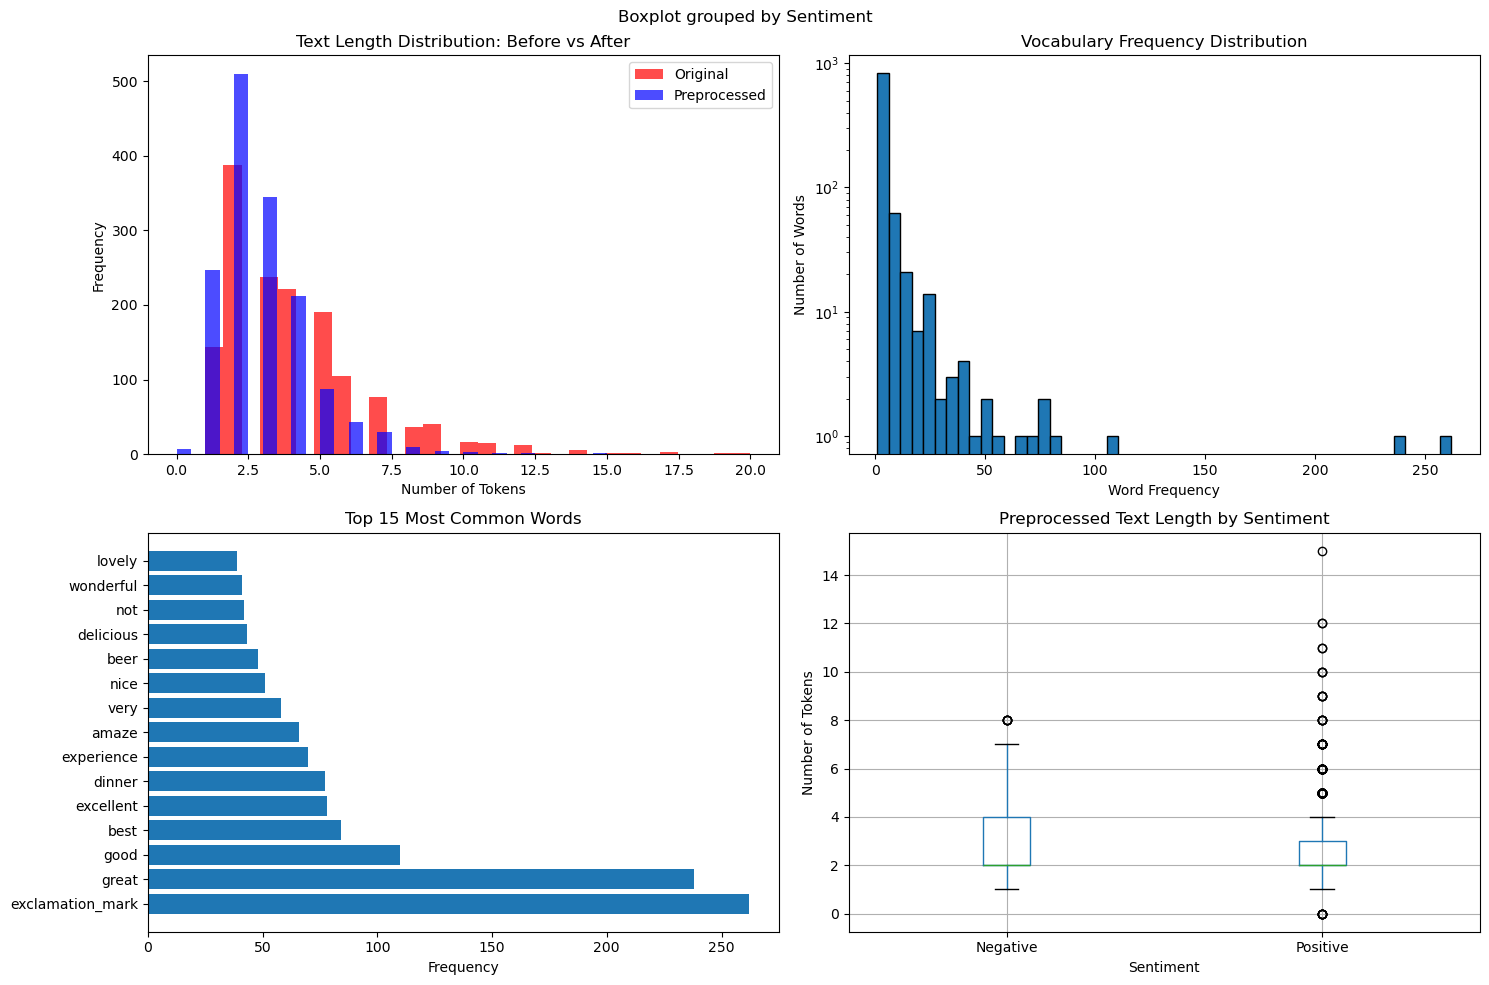


PREPROCESSING PIPELINE SUMMARY
PIPELINE DESIGN RATIONALE:
1. DOMAIN-AWARE: Customized for restaurant reviews with food/service terminology
2. SENTIMENT-PRESERVING: Keeps emotionally charged words and negations
3. COMPREHENSIVE: Handles contractions, emoticons, misspellings
4. CONFIGURABLE: Easy to adjust for different analysis needs
5. DOCUMENTED: Full statistics and examples provided

KEY PREPROCESSING DECISIONS:
✓ Preserved sentiment indicators (not, very, excellent, terrible, etc.)
✓ Converted emoticons to sentiment tokens
✓ Expanded contractions for better analysis
✓ Applied domain-specific spelling corrections
✓ Used lemmatization instead of stemming for better readability
✓ Kept exclamation/question marks as sentiment intensity indicators
✓ Removed generic restaurant terms while preserving specific descriptors

FINAL PREPROCESSED DATASET:
Shape: (1502, 9)
Columns: ['Country', 'Restaurant Name', 'Sentiment', 'Review Title', 'Review Date', 'Review', 'preprocessed_tokens', 'preproc

In [10]:

# Download required NLTK data - more comprehensive approach
print("Ensuring all NLTK resources are available...")

nltk_resources = [
    'punkt',
    'stopwords', 
    'wordnet',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng',  # Specific for English
    'maxent_ne_chunker',
    'words',
    'omw-1.4'
]

for resource in nltk_resources:
    try:
        # Try to find the resource in different possible locations
        try:
            nltk.data.find(f'tokenizers/{resource}')
        except LookupError:
            try:
                nltk.data.find(f'corpora/{resource}')
            except LookupError:
                try:
                    nltk.data.find(f'taggers/{resource}')
                except LookupError:
                    try:
                        nltk.data.find(f'chunkers/{resource}')
                    except LookupError:
                        # Resource not found, download it
                        print(f"Downloading NLTK resource: {resource}")
                        nltk.download(resource, quiet=False)
    except Exception as e:
        print(f"Note: Could not download {resource}, will use fallback methods")

# Read the dataset
df = pd.read_csv('data\\European Restaurant Reviews.csv')

print("="*80)
print("PROBLEM 3: TEXT PREPROCESSING PIPELINE FOR RESTAURANT REVIEWS")
print("="*80)

# Identify text and sentiment columns
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower()]

text_col = text_columns[0] if text_columns else None
sentiment_col = sentiment_columns[0] if sentiment_columns else None

print(f"Working with text column: '{text_col}'")
print(f"Working with sentiment column: '{sentiment_col}'")

# Clean initial dataset
df_work = df.dropna(subset=[text_col, sentiment_col]).copy()
print(f"Dataset size after removing missing values: {len(df_work)} reviews")

print("\n" + "="*80)
print("PREPROCESSING PIPELINE DESIGN")
print("="*80)

class RestaurantReviewPreprocessor:
    """
    Comprehensive preprocessing pipeline specifically designed for restaurant reviews
    and sentiment analysis tasks.
    """
    
    def __init__(self, preserve_sentiment_indicators=True, remove_stopwords=True, 
                 lemmatize=True, min_word_length=2):
        """
        Initialize the preprocessor with configurable options.
        
        Args:
            preserve_sentiment_indicators (bool): Keep emotionally charged words
            remove_stopwords (bool): Remove common stop words
            lemmatize (bool): Apply lemmatization
            min_word_length (int): Minimum word length to keep
        """
        self.preserve_sentiment_indicators = preserve_sentiment_indicators
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.min_word_length = min_word_length
        
        # Initialize NLTK tools
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Domain-specific customizations for restaurant reviews
        self.setup_domain_specific_rules()
        
        # Track preprocessing statistics
        self.stats = defaultdict(int)
        
    def setup_domain_specific_rules(self):
        """Setup rules specific to restaurant review domain"""
        
        # Restaurant-specific stop words to remove
        self.domain_stopwords = {
            'restaurant', 'place', 'food', 'service', 'staff', 'time', 'go', 'went', 'come', 'came'
        }
        
        # Sentiment-important words to preserve (never remove as stopwords)
        self.sentiment_words = {
            # Positive sentiment indicators
            'excellent', 'amazing', 'fantastic', 'wonderful', 'perfect', 'outstanding',
            'delicious', 'tasty', 'fresh', 'hot', 'warm', 'friendly', 'helpful',
            'quick', 'fast', 'clean', 'beautiful', 'cozy', 'romantic', 'authentic',
            'recommend', 'love', 'loved', 'enjoy', 'enjoyed', 'impressed', 'satisfied',
            
            # Negative sentiment indicators  
            'terrible', 'awful', 'horrible', 'disgusting', 'nasty', 'bland', 'tasteless',
            'cold', 'frozen', 'overcooked', 'undercooked', 'burnt', 'stale', 'soggy',
            'rude', 'unfriendly', 'slow', 'dirty', 'expensive', 'overpriced',
            'disappointed', 'dissatisfied', 'hate', 'hated', 'avoid', 'never', 'worst',
            
            # Intensity modifiers
            'very', 'extremely', 'quite', 'really', 'absolutely', 'completely',
            'totally', 'incredibly', 'amazingly', 'surprisingly', 'definitely',
            
            # Negation words (crucial for sentiment)
            'not', 'no', 'never', 'nothing', 'nobody', 'nowhere', 'neither',
            'none', 'hardly', 'scarcely', 'barely', 'seldom', 'rarely'
        }
        
        # Common restaurant misspellings and their corrections
        self.spelling_corrections = {
            'restaurent': 'restaurant',
            'restaraunt': 'restaurant', 
            'resturant': 'restaurant',
            'definitly': 'definitely',
            'delicous': 'delicious',
            'reccomend': 'recommend',
            'recomend': 'recommend',
            'awsome': 'awesome',
            'greatness': 'great',
            'amazng': 'amazing'
        }
        
        # Emoticons and their sentiment meanings
        self.emoticon_mapping = {
            ':)': 'positive_emoticon',
            ':-)': 'positive_emoticon',
            ':(': 'negative_emoticon',
            ':-(': 'negative_emoticon',
            ':D': 'very_positive_emoticon',
            ':-D': 'very_positive_emoticon',
            ';)': 'positive_emoticon',
            ';-)': 'positive_emoticon',
            ':|': 'neutral_emoticon',
            ':-|': 'neutral_emoticon',
        }
        
    def basic_cleaning(self, text):
        """Apply basic text cleaning operations"""
        if pd.isna(text) or text == '':
            return ''
            
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Handle contractions (expand them for better sentiment analysis)
        contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
            "'m": " am", "it's": "it is", "that's": "that is",
            "what's": "what is", "here's": "here is", "there's": "there is"
        }
        
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        
        # Handle emoticons before removing punctuation
        for emoticon, sentiment_token in self.emoticon_mapping.items():
            text = text.replace(emoticon, f' {sentiment_token} ')
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Handle special characters but preserve important punctuation for sentiment
        # Keep exclamation marks and question marks as they indicate sentiment intensity
        text = re.sub(r'[^\w\s!?]', ' ', text)
        
        # Replace multiple exclamation/question marks with single tokens
        text = re.sub(r'!+', ' exclamation_mark ', text)
        text = re.sub(r'\?+', ' question_mark ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def apply_spelling_corrections(self, text):
        """Apply domain-specific spelling corrections"""
        words = text.split()
        corrected_words = []
        
        for word in words:
            if word in self.spelling_corrections:
                corrected_words.append(self.spelling_corrections[word])
                self.stats['spelling_corrections'] += 1
            else:
                corrected_words.append(word)
        
        return ' '.join(corrected_words)
    
    def tokenize_and_filter(self, text):
        """Tokenize text and apply filtering rules"""
        # Tokenize
        tokens = word_tokenize(text)
        
        # Filter tokens
        filtered_tokens = []
        
        for token in tokens:
            # Skip very short tokens (but keep important short sentiment words)
            if len(token) < self.min_word_length and token not in ['no', 'ok', 'go']:
                self.stats['short_tokens_removed'] += 1
                continue
            
            # Skip pure numbers (unless they might be ratings)
            if token.isdigit() and len(token) > 2:
                self.stats['numbers_removed'] += 1
                continue
                
            # Handle stopwords with sentiment awareness
            if self.remove_stopwords:
                if (token in self.stop_words and 
                    token not in self.sentiment_words and
                    not token.endswith('_emoticon') and
                    token not in ['exclamation_mark', 'question_mark']):
                    self.stats['stopwords_removed'] += 1
                    continue
            
            # Remove domain-specific common words (unless sentiment-relevant)
            if token in self.domain_stopwords and token not in self.sentiment_words:
                self.stats['domain_stopwords_removed'] += 1
                continue
            
            filtered_tokens.append(token)
        
        return filtered_tokens
    
    def apply_lemmatization(self, tokens):
        """Apply lemmatization while preserving sentiment indicators"""
        if not self.lemmatize:
            return tokens
        
        lemmatized = []
        for token in tokens:
            # Don't lemmatize special tokens we created
            if token.endswith('_emoticon') or token in ['exclamation_mark', 'question_mark']:
                lemmatized.append(token)
            else:
                try:
                    # Get POS tag for better lemmatization
                    pos = pos_tag([token])[0][1]
                    if pos.startswith('V'):  # Verb
                        lemma = self.lemmatizer.lemmatize(token, pos='v')
                    elif pos.startswith('N'):  # Noun
                        lemma = self.lemmatizer.lemmatize(token, pos='n')
                    elif pos.startswith('J'):  # Adjective
                        lemma = self.lemmatizer.lemmatize(token, pos='a')
                    elif pos.startswith('R'):  # Adverb
                        lemma = self.lemmatizer.lemmatize(token, pos='r')
                    else:
                        lemma = self.lemmatizer.lemmatize(token)
                    
                    lemmatized.append(lemma)
                    if lemma != token:
                        self.stats['words_lemmatized'] += 1
                        
                except Exception as e:
                    # Fallback: simple lemmatization without POS tagging
                    try:
                        lemma = self.lemmatizer.lemmatize(token)
                        lemmatized.append(lemma)
                        if lemma != token:
                            self.stats['words_lemmatized'] += 1
                    except:
                        # Last resort: keep original token
                        lemmatized.append(token)
        
        return lemmatized
    
    def preprocess_text(self, text):
        """Complete preprocessing pipeline for a single text"""
        # Step 1: Basic cleaning
        cleaned = self.basic_cleaning(text)
        if not cleaned:
            return []
        
        # Step 2: Spelling corrections
        corrected = self.apply_spelling_corrections(cleaned)
        
        # Step 3: Tokenization and filtering
        tokens = self.tokenize_and_filter(corrected)
        
        # Step 4: Lemmatization
        lemmatized = self.apply_lemmatization(tokens)
        
        self.stats['texts_processed'] += 1
        return lemmatized
    
    def preprocess_corpus(self, texts):
        """Preprocess entire corpus of texts"""
        self.stats = defaultdict(int)  # Reset stats
        
        processed_texts = []
        for text in texts:
            processed = self.preprocess_text(text)
            processed_texts.append(processed)
        
        return processed_texts
    
    def get_preprocessing_stats(self):
        """Return preprocessing statistics"""
        return dict(self.stats)

# Initialize preprocessor
print("Initializing Restaurant Review Preprocessor...")
print("Configuration:")
print("  ✓ Preserve sentiment indicators: True")
print("  ✓ Remove stopwords: True (with sentiment awareness)")
print("  ✓ Apply lemmatization: True")
print("  ✓ Minimum word length: 2")
print("  ✓ Domain-specific rules for restaurants: Enabled")

preprocessor = RestaurantReviewPreprocessor()

print(f"\nDomain-specific customizations loaded:")
print(f"  • Sentiment words preserved: {len(preprocessor.sentiment_words)}")
print(f"  • Restaurant stopwords: {len(preprocessor.domain_stopwords)}")
print(f"  • Spelling corrections: {len(preprocessor.spelling_corrections)}")
print(f"  • Emoticon mappings: {len(preprocessor.emoticon_mapping)}")

# Show examples of preprocessing steps
print("\n" + "="*80)
print("PREPROCESSING EXAMPLES AND DEMONSTRATION")
print("="*80)

# Select sample reviews for demonstration
sample_reviews = df_work[text_col].sample(5).tolist()

print("STEP-BY-STEP PREPROCESSING EXAMPLES:")
print("-" * 50)

for i, review in enumerate(sample_reviews, 1):
    print(f"\nEXAMPLE {i}:")
    print(f"Original: '{review[:100]}...'")
    
    # Show each preprocessing step
    cleaned = preprocessor.basic_cleaning(review)
    print(f"After basic cleaning: '{cleaned[:80]}...'")
    
    corrected = preprocessor.apply_spelling_corrections(cleaned)
    if corrected != cleaned:
        print(f"After spelling correction: '{corrected[:80]}...'")
    
    tokens = preprocessor.tokenize_and_filter(corrected)
    print(f"After tokenization/filtering: {tokens[:15]}...")
    
    final_tokens = preprocessor.apply_lemmatization(tokens)
    print(f"Final preprocessed: {final_tokens[:15]}...")
    
    if i >= 3:  # Show only first 3 examples to save space
        break

print("\n" + "="*80)
print("FULL CORPUS PREPROCESSING")
print("="*80)

# Preprocess entire corpus
print("Preprocessing entire corpus...")
all_reviews = df_work[text_col].tolist()
preprocessed_reviews = preprocessor.preprocess_corpus(all_reviews)

# Add preprocessed data to dataframe
df_work['preprocessed_tokens'] = preprocessed_reviews
df_work['preprocessed_text'] = [' '.join(tokens) for tokens in preprocessed_reviews]
df_work['token_count'] = [len(tokens) for tokens in preprocessed_reviews]

# Show preprocessing statistics
stats = preprocessor.get_preprocessing_stats()
print("\nPREPROCESSING STATISTICS:")
print("-" * 40)
for stat_name, count in stats.items():
    print(f"{stat_name.replace('_', ' ').title()}: {count:,}")

print(f"\nCORPUS OVERVIEW AFTER PREPROCESSING:")
print(f"Total reviews processed: {len(preprocessed_reviews):,}")
print(f"Average tokens per review: {np.mean([len(tokens) for tokens in preprocessed_reviews]):.1f}")
print(f"Total unique tokens: {len(set(token for tokens in preprocessed_reviews for token in tokens)):,}")

# Vocabulary analysis
print("\n" + "="*80)
print("VOCABULARY ANALYSIS")
print("="*80)

# Create vocabulary statistics
all_tokens = [token for tokens in preprocessed_reviews for token in tokens]
vocab_counter = Counter(all_tokens)

print(f"VOCABULARY STATISTICS:")
print(f"Total tokens in corpus: {len(all_tokens):,}")
print(f"Unique vocabulary size: {len(vocab_counter):,}")
print(f"Average word frequency: {len(all_tokens) / len(vocab_counter):.2f}")

# Most common words overall
print(f"\nMOST COMMON WORDS (TOP 20):")
for word, freq in vocab_counter.most_common(20):
    print(f"  {word}: {freq:,}")

# Analyze vocabulary by sentiment
print(f"\nVOCABULARY BY SENTIMENT:")
sentiment_vocabs = {}
for sentiment in df_work[sentiment_col].unique():
    sentiment_reviews = df_work[df_work[sentiment_col] == sentiment]['preprocessed_tokens'].tolist()
    sentiment_tokens = [token for tokens in sentiment_reviews for token in tokens]
    sentiment_vocabs[sentiment] = Counter(sentiment_tokens)
    
    print(f"\n{sentiment.upper()} REVIEWS:")
    print(f"  Total tokens: {len(sentiment_tokens):,}")
    print(f"  Unique words: {len(sentiment_vocabs[sentiment]):,}")
    print(f"  Top words: {[word for word, _ in sentiment_vocabs[sentiment].most_common(10)]}")

# Identify sentiment-discriminative words
print(f"\nSENTIMENT-DISCRIMINATIVE WORDS:")
if len(sentiment_vocabs) == 2:
    sentiments = list(sentiment_vocabs.keys())
    sent1, sent2 = sentiments[0], sentiments[1]
    
    # Words more common in sentiment 1
    sent1_distinctive = []
    sent2_distinctive = []
    
    for word in vocab_counter.most_common(200):  # Check top 200 words
        word = word[0]
        if word in sentiment_vocabs[sent1] and word in sentiment_vocabs[sent2]:
            freq1 = sentiment_vocabs[sent1][word] / sum(sentiment_vocabs[sent1].values())
            freq2 = sentiment_vocabs[sent2][word] / sum(sentiment_vocabs[sent2].values())
            
            ratio = freq1 / freq2 if freq2 > 0 else float('inf')
            
            if ratio > 2.0:  # Much more common in sentiment 1
                sent1_distinctive.append((word, ratio))
            elif ratio < 0.5:  # Much more common in sentiment 2
                sent2_distinctive.append((word, 1/ratio))
    
    print(f"\nWords more associated with {sent1}:")
    for word, ratio in sorted(sent1_distinctive, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {word} (ratio: {ratio:.2f})")
    
    print(f"\nWords more associated with {sent2}:")
    for word, ratio in sorted(sent2_distinctive, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {word} (ratio: {ratio:.2f})")

# Visualizations
print("\n" + "="*80)
print("PREPROCESSING IMPACT VISUALIZATION")
print("="*80)

# Before/after comparison
original_lengths = [len(str(text).split()) for text in df_work[text_col]]
preprocessed_lengths = df_work['token_count'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Preprocessing Impact Analysis', fontsize=16)

# Length comparison
axes[0, 0].hist(original_lengths, bins=30, alpha=0.7, label='Original', color='red')
axes[0, 0].hist(preprocessed_lengths, bins=30, alpha=0.7, label='Preprocessed', color='blue')
axes[0, 0].set_xlabel('Number of Tokens')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution: Before vs After')
axes[0, 0].legend()

# Vocabulary frequency distribution
vocab_freqs = list(vocab_counter.values())
axes[0, 1].hist(vocab_freqs, bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Word Frequency')
axes[0, 1].set_ylabel('Number of Words')
axes[0, 1].set_title('Vocabulary Frequency Distribution')
axes[0, 1].set_yscale('log')

# Most common words
top_words = [word for word, _ in vocab_counter.most_common(15)]
top_freqs = [freq for _, freq in vocab_counter.most_common(15)]
axes[1, 0].barh(range(len(top_words)), top_freqs)
axes[1, 0].set_yticks(range(len(top_words)))
axes[1, 0].set_yticklabels(top_words)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Top 15 Most Common Words')

# Token count by sentiment
df_work.boxplot(column='token_count', by=sentiment_col, ax=axes[1, 1])
axes[1, 1].set_title('Preprocessed Text Length by Sentiment')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Number of Tokens')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PREPROCESSING PIPELINE SUMMARY")
print("="*80)

print("PIPELINE DESIGN RATIONALE:")
print("1. DOMAIN-AWARE: Customized for restaurant reviews with food/service terminology")
print("2. SENTIMENT-PRESERVING: Keeps emotionally charged words and negations")
print("3. COMPREHENSIVE: Handles contractions, emoticons, misspellings")
print("4. CONFIGURABLE: Easy to adjust for different analysis needs")
print("5. DOCUMENTED: Full statistics and examples provided")

print(f"\nKEY PREPROCESSING DECISIONS:")
print(f"✓ Preserved sentiment indicators (not, very, excellent, terrible, etc.)")
print(f"✓ Converted emoticons to sentiment tokens")
print(f"✓ Expanded contractions for better analysis")
print(f"✓ Applied domain-specific spelling corrections")
print(f"✓ Used lemmatization instead of stemming for better readability")
print(f"✓ Kept exclamation/question marks as sentiment intensity indicators")
print(f"✓ Removed generic restaurant terms while preserving specific descriptors")

print(f"\nFINAL PREPROCESSED DATASET:")
print(f"Shape: {df_work.shape}")
print(f"Columns: {list(df_work.columns)}")
print(f"Ready for sentiment analysis tasks!")

# Save preprocessed data
output_file = 'data\\preprocessed_restaurant_reviews.csv'
df_work.to_csv(output_file, index=False)
print(f"\nPreprocessed data saved to: {output_file}")

print("="*80)

### Problem 4. Top words (1 point)
Use a simple word tokenization and count the top 10 words in positive reviews; then the top 10 words in negative reviews*. Once again, try to define what "top" words means. Describe and document your process. Explain your results.

\* Okay, you may want to see top N words (with $N \ge 10$).

### Problem 5. Review titles (2 point)
How do the top words you found in the last problem correlate to the review titles? Do the top 10 words (for each sentiment) appear in the titles at all? Do reviews which contain one or more of the top words have the same words in their titles?

Does the title of a comment present a good summary of its content? That is, are the titles descriptive, or are they simply meant to catch the attention of the reader?

### Problem 6. Bag of words (1 point)
Based on your findings so far, come up with a good set of settings (hyperparameters) for a bag-of-words model for review titles and contents. It's easiest to treat them separately (so, create two models); but you may also think about a unified representation. I find the simplest way of concatenating the title and content too simplistic to be useful, as it doesn't allow you to treat the title differently (e.g., by giving it more weight).

The documentation for `CountVectorizer` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Familiarize yourself with all settings; try out different combinations and come up with a final model; or rather - two models :).

### Problem 7. Deep sentiment analysis models (1 point)
Find a suitable model for sentiment analysis in English. Without modifying, training, or fine-tuning the model, make it predict all contents (or better, combinations of titles and contents, if you can). Meaure the accuracy of the model compared to the `sentiment` column in the dataset.

### Problem 8. Deep features (embeddings) (1 point)
Use the same model to perform feature extraction on the review contents (or contents + titles) instead of direct predictions. You should already be familiar how to do that from your work on images.

Use the cosine similarity between texts to try to cluster them. Are there "similar" reviews (you'll need to find a way to measure similarity) across different restaurants? Are customers generally in agreement for the same restaurant?

### \* Problem 9. Explore and model at will
In this lab, we focused on preprocessing and feature extraction and we didn't really have a chance to train (or compare) models. The dataset is maybe too small to be conclusive, but feel free to play around with ready-made models, and train your own.